In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy
import matplotlib.pyplot as plt
from template_funciones import *


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

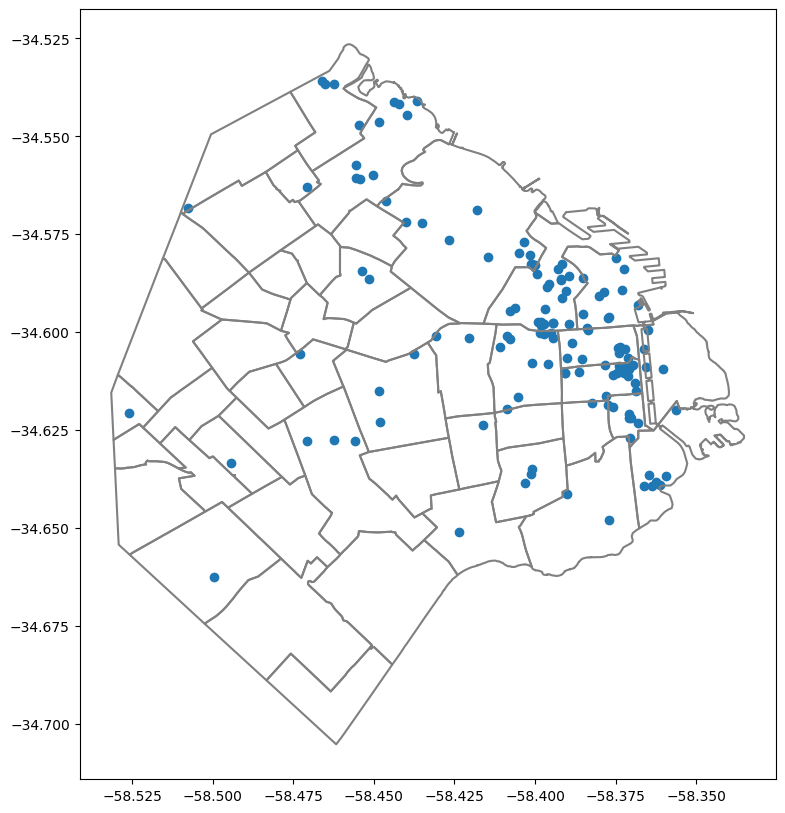

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184. 

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa), 
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m): 
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
def construir_grafo(m):
    A = construye_adyacencia(D,m)
    G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
    # Construimos un layout a partir de las coordenadas geográficas
    G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
    return G, G_layout

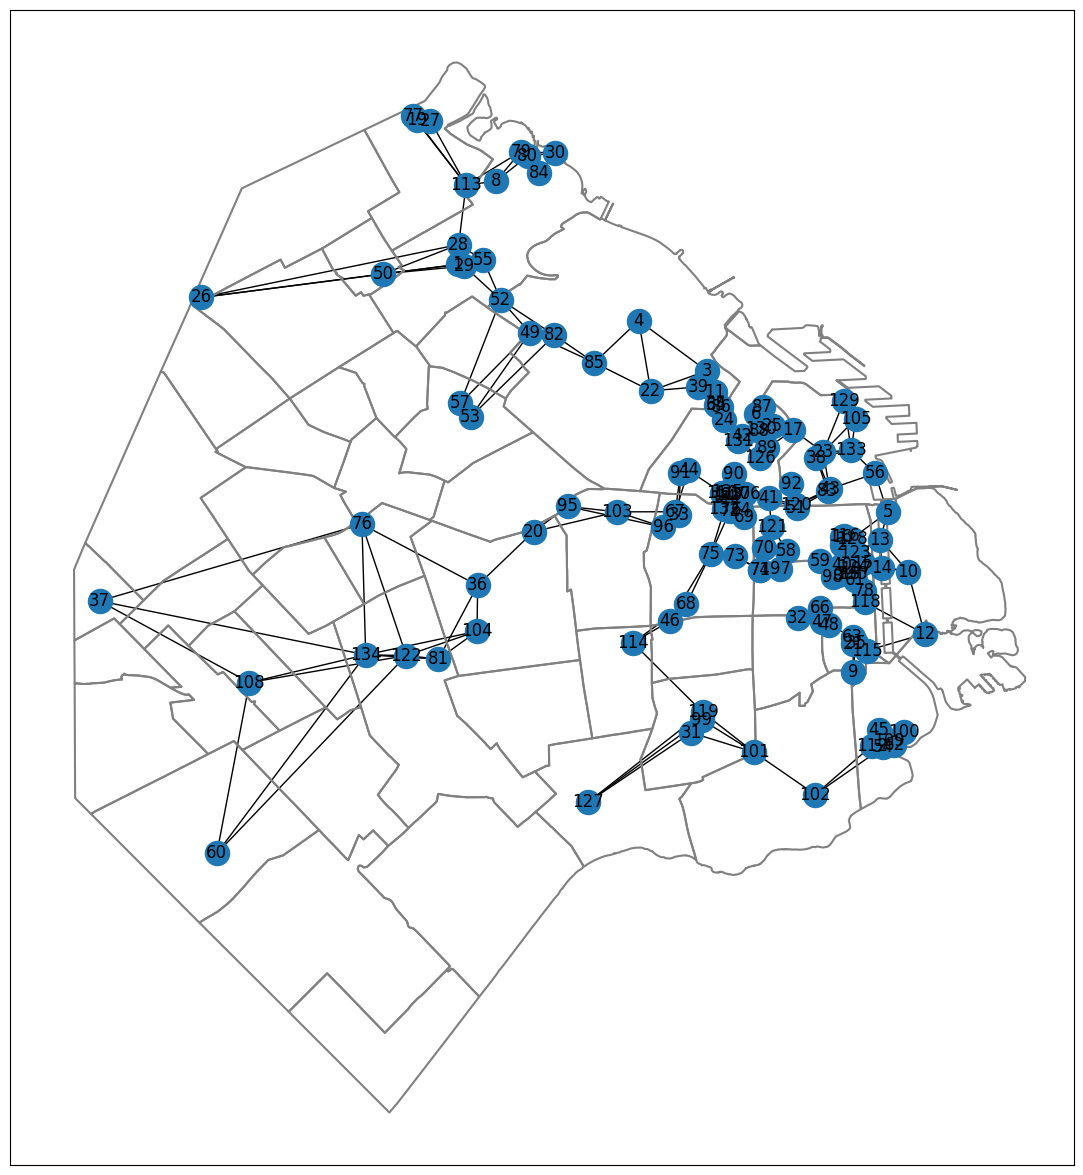

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
G, G_layout = construir_grafo(3)
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

## Ejercicio 1

$$p = (1-\alpha) C p + \frac{\alpha}{N} 1 $$

Luego 

$$ - \frac{\alpha}{N} \overrightarrow{1} = (1-\alpha) C p - p $$

$$ - \frac{\alpha}{N} \overrightarrow{1} = ((1-\alpha) C - I)p  $$

$$ \overrightarrow{1} = -\frac{N}{\alpha} ((1-\alpha) C - I)p  $$

Distribuyendo el menos dentro del paréntesis...

$$ \overrightarrow{1} = \frac{N}{\alpha} (I - (1-\alpha) C)p  $$

$$ \overrightarrow{1} = Mp  $$

Tal como queriamos ver.

## Punto 2:


Para que M tenga solo una solucion, debemos poder triangularla con el vector de unos y obtener un SCD. Para que suceda esto, necesitamos que tenga solucion. Vemos particularmente que si M es LD vamos a poder escribir a un vector como CL de los otros, es decir que nos quedaría una fila toda llena de ceros. Y al igualarla con el vector de unos, eso nos quedaria un sistema incompatible. Es decir que, o tiene una solucion o no tiene ninguna.

Entonces, **necesitamos** que su determinante sea distinto a cero (que sea LI), para que sea SCD.

Vemos que M tiene esta forma

$$ M = \frac{n}{\alpha} (I - (1-\alpha)C) $$
$$ M = \frac{n}{\alpha} (I + (\alpha-1)C) $$
$$ M = \frac{n}{\alpha} H $$

Donde $H$ es $I + (\alpha-1)C$.

Luego, nos basta con analizar que H sea inversible para determinar que hay una solucion unica para el sistema anterior, puesto que $\alpha -1$ es un escalar.

También podemos ver que si demostramos que $H^t$ es inversible, entonces $H$ es inversible.

Vamos a demostrarlo con la propiedad de EDD: Estrictamente diagonal dominante. Si $H^t$ es EDD, entonces $H^t$ es inversible, entonces $H$ es inversible.

Quiero ver que:

$$ \sum_{j=1, j\neq i}^{n} |h^{t}_{ij}| < |h^{t}_{ii}|$$

Vemos que: $ h^{t}_{ii} = 1 + (\alpha-1)c_{ii} $. Pero $c_{ii} = 0$ para todo $i$, entonces $h^{t}_{ii} = h_{ii}= 1$, para todo $i=1...n$.


Para justificar que $c_{ii}$ = 0, vemos que si usamos la definicion "mas general" es obvio, se desprende de la definicion misma. Si usamos la otra definicion, $C = A^t K^{-1}$, usamos que A, y por ende la matriz $A^t$, tienen ceros en la diagonal (por la definicion de A)

Como $K$ es diagonal, $K^{-1}$ tambien lo es. Luego, vemos que $(A^t K^{-1})_{ij} = (A^t)_{ij} \cdot (K^{-1})_{jj}$, puesto que $K^{-1}$ tiene todos ceros excepto en la diagonal. Luego, esta última expresión es lo mismo que decir $A_{ji} \cdot \frac{1}{K_{jj}}$. Si vemos esta expresion en la diagonal, nos queda que $A_{ii} \cdot \frac{1}{K_{jj}}$ es cero, porque la diagonal de A es cero. Luego, $c_{ii}$ es cero.



Luego, vemos que del otro lado de la desigualdad podemos reescribir la expresion como

$$ \sum_{j=1, j\neq i}^{n} |h^{t}_{ij}| = \sum_{j=1, j\neq i}^{n} |(\alpha-1)c^{t}_{ij}| = |\alpha-1| \sum_{j=1, j\neq i}^{n} |c^{t}_{ij}| $$

El primer paso lo vemos porque la sumatoria no incluye la diagonal. Por la forma de la matriz H, sabemos que las posiciones que no son la diagonal van a ser las de C.

Luego, vemos que a esa expresion la podemos reescribir como:

$$ (1-\alpha) \cdot 1 $$

Primero, porque como $0\lt \alpha \lt 1$, entonces $1-\alpha$ es positivo. Luego, vemos que como $C$ es una matriz estocastica, entonces cada una de sus columnas suma 1. Luego, las filas de $C^t$ suman 1.

Luego, vemos que:

$$ 1-\alpha < 1 $$

$$ \alpha > 0 $$

Que vale siempre, puesto que $0\lt \alpha \lt 1$.

∎

## Punto 3:

Encontrar el vector $\mathbf{p} = M^{-1} \mathbf{b}$

### [a]

/Users/pedranji/Projects/ALC-tp1/tp1/template_funciones.py:57: RuntimeWarning: divide by zero encountered in matmul
  C = A.T @ Kinv
/Users/pedranji/Projects/ALC-tp1/tp1/template_funciones.py:57: RuntimeWarning: overflow encountered in matmul
  C = A.T @ Kinv
/Users/pedranji/Projects/ALC-tp1/tp1/template_funciones.py:57: RuntimeWarning: invalid value encountered in matmul
  C = A.T @ Kinv


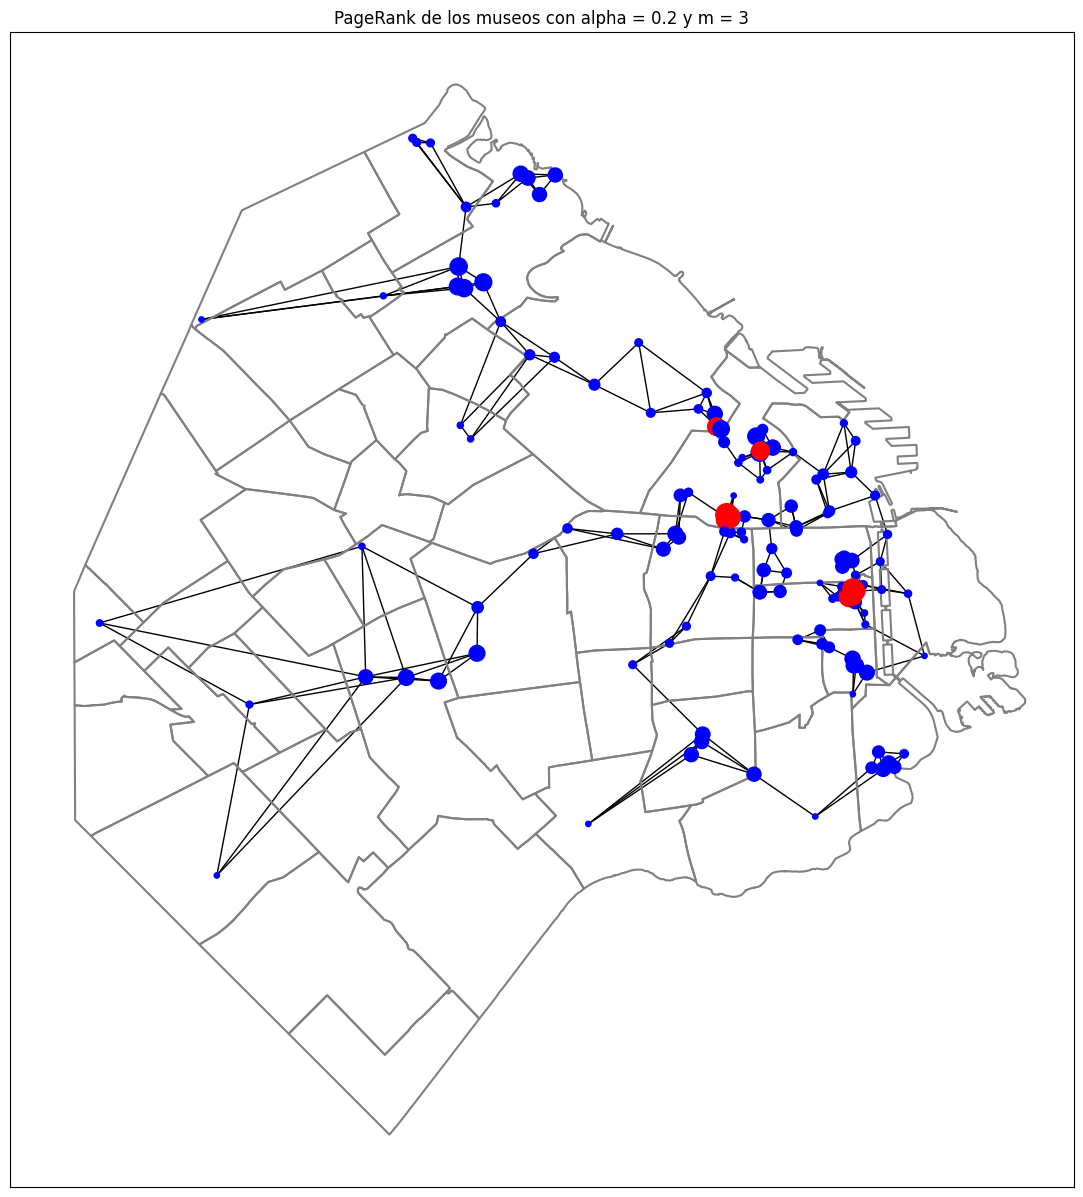

In [ ]:
from template_funciones import *


def plotPageRank(p, alpha, m):
    G, G_layout = construir_grafo(m)

    factor_escala = 1e4
    p_normalized = p / p.sum()
    fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa

    # Graficamos Los barrios
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)

    # Identify top 10 nodes
    nodes_list = list(G.nodes)
    if isinstance(p, dict): # Handle case where p might be a dict {node: score}
        # Ensure the order matches G.nodes before sorting
        p_array = np.array([p.get(node, 0) for node in nodes_list])
    else: # Assuming p is a numpy array corresponding to G.nodes order
        p_array = np.array(p)

    if len(p_array) != len(nodes_list):
        print("Warning: PageRank vector length doesn't match the number of nodes.")
        # Fallback or error handling needed here depending on requirements
        # For now, proceeding with potentially incorrect mapping
        top_10_nodes = [] # Or handle error appropriately
    else:
        top_10_indices = np.argsort(p_array)[-10:]
        top_10_nodes = [nodes_list[i] for i in top_10_indices]

    # Assign colors: red for top 10, blue for others
    node_colors = ['red' if node in top_10_nodes else 'blue' for node in G.nodes()]

    # Graficamos los museos con tamaño proporcional al pagerank y colores distintivos
    nx.draw_networkx(
        G,
        G_layout,
        ax=ax,
        node_size=p_normalized * factor_escala,
        node_color=node_colors, # Use the generated color list
        with_labels=False # Ensure no labels are drawn by default draw_networkx
    )

    plt.title(f"PageRank de los museos con alpha = {alpha} y m = {m}")
    plt.show()

def buildAndCalculatePageRank(m, alpha):
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, alpha)
    return p

def calculateAndPlotPageRank(alpha, m):
    p = buildAndCalculatePageRank(m, alpha)
    plotPageRank(p, alpha, m)

p = buildAndCalculatePageRank(3, 0.2)

calculateAndPlotPageRank(alpha=0.2, m=3)

print(f"puntajes de museos =  {p}")
##print(f"suma = {np.sum(p)}") debe dar 1 para que p sea solucion 

### [b y c]

In [9]:
M = (1,3,5,10,15,20)
Alpha = (1/5, 4/5, 1/2, 1/3, 1/7)
TestCases = [ {'m':m, 'alpha':a} for a in Alpha for m in M ]
Results = []

## Calcula y dibuja los resultados para cada testCase pedido
for testCase in TestCases:
    p = buildAndCalculatePageRank(alpha=testCase['alpha'], m=testCase['m'])
    Results.append({'m':testCase['m'], 'alpha':testCase['alpha'], 'pagerank':p})
    # plotPageRank(p, testCase['alpha'], testCase['m'])

/Users/pedranji/Projects/ALC-tp1/tp1/template_funciones.py:57: RuntimeWarning: divide by zero encountered in matmul
  C = A.T @ Kinv
/Users/pedranji/Projects/ALC-tp1/tp1/template_funciones.py:57: RuntimeWarning: overflow encountered in matmul
  C = A.T @ Kinv
/Users/pedranji/Projects/ALC-tp1/tp1/template_funciones.py:57: RuntimeWarning: invalid value encountered in matmul
  C = A.T @ Kinv


### [d]

Los museos que más veces aparecen en los top3 son:  [135  18 117]


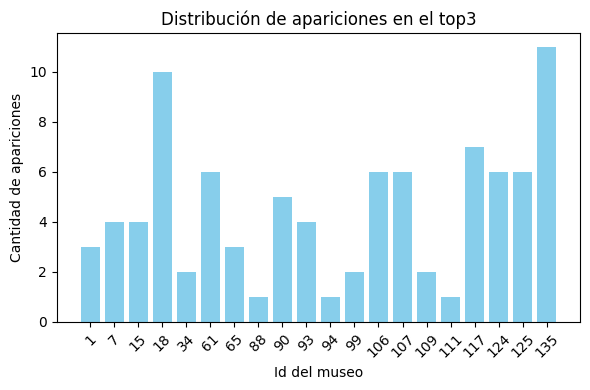

In [10]:
# Vemos los 3 museos que más veces aparecen en los top3

def getTop3(p):
    return np.argsort(p)[-3:][::-1] 

museumAparition = np.zeros(D.shape[0])
for i, data in enumerate(Results):
    m = data['m']
    alpha = data['alpha']
    p = data['pagerank']
    top3 = getTop3(p)    
    for j in top3:
        museumAparition[j] += 1

print("Los museos que más veces aparecen en los top3 son: ", np.argsort(museumAparition)[-3:][::-1])

def plotAparitionsDistribution(aparitionCounter, title):
    top_indices = range(0, len(aparitionCounter))
    top_values = aparitionCounter[top_indices]
    df = pd.DataFrame({
        'Index': top_indices,
        'Value': top_values
    })
    df['Index'] = df['Index'].astype(str)
    df = df[df['Value'] > 0]
    plt.figure(figsize=(6, 4))
    plt.bar(df['Index'], df['Value'], color='skyblue')
    plt.title(title)
    plt.xlabel('Id del museo')
    plt.xticks(rotation=45)
    plt.ylabel('Cantidad de apariciones')
    plt.tight_layout()
    plt.show()

plotAparitionsDistribution(museumAparition, "Distribución de apariciones en el top3")

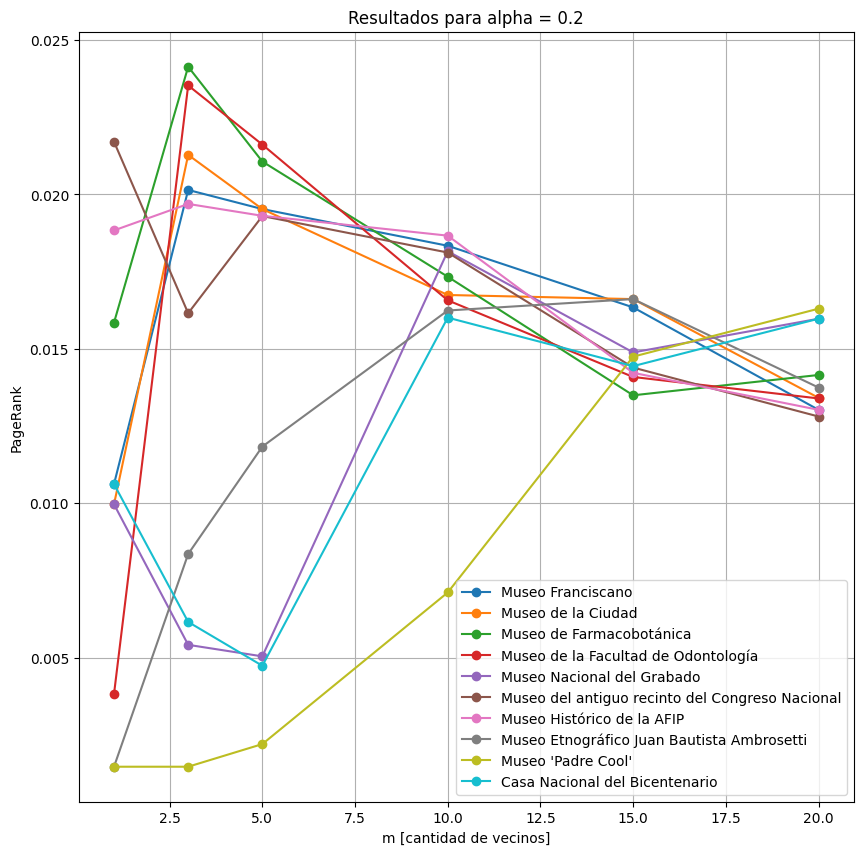

In [11]:
# Graficamos los resultados para los museos para un alpha fijo y M variado      

def plotResults(results, museumIds, alpha):
    fig, ax = plt.subplots(figsize=(10, 10))
    points = { museumId: [] for museumId in museumIds }
    results = list(filter(lambda x: x['alpha'] == alpha, results))
    for data in results:
        m = data['m']
        p = data['pagerank']           
        for museumId in museumIds:
            points[museumId].append((m, p[museumId]))
    for museumId, museumPoints in points.items():
        x = [point[0] for point in museumPoints]
        y = [point[1] for point in museumPoints]
        museumName = museos.iloc[museumId]['name']
        ax.plot(x, y, 'o-', label=f'{museumName}')  
    ax.set_title(f"Resultados para alpha = {alpha}")
    ax.legend()
    ax.set_xlabel('m [cantidad de vecinos]')
    ax.set_ylabel('PageRank')
    plt.grid(True)
    plt.show()


plotResults(results=Results, museumIds=np.argsort(museumAparition)[-10:][::-1], alpha=0.2)

### Conclusion:

Vemos que al incrementar la cantidad de vecinos el ranking se modifica. La ubicacion del top arranca siendo más disperso y notamos que la diferencia entre pageRanks se achica a medida que se aumenta la cantidad de vecinos (se emparejan).

Las locaciones mas importantes son en Recoleta y eso se mantiene para los distintos m. A medida que aumenta la cantidad de vecinos, todo tiende a la zona de Recoleta/Centro.

## Punto 4:

Queremos ver que con $Bv = w$ podemos estimar el vector v. Recordamos que $w_i$ es la cantidad TOTAL de personas que estuvieron en el museo $i$, en cualquier momento, no solo al final.

Si $r = 0$, es facil ver que esto vale. $v_i$ es la cantidad de personas que tuvieron al museo $i$ como punto de entrada a la red. Y si $r=0$, $B = C^0 = I$, entonces vale.

Luego, vemos que para $r=1$ tendriamos que considerar, para $w_j$ todos los que fueron de cualquier museo, al museo $j$. Es decir, la sumatoria de probabilidades de ir del museo $i$ al $j$, multiplicado por la cantidad de personas que entraron al museo $i$, para todo $i=1...n$

Es decir $$w_j = \sum_{i=1}^{n}{C_{ij} \cdot v_i}$$

La ecuacion que queremos ver que vale es 

$$w_j = \sum_{i=1}^{n}{B_{ij} \cdot v_i}$$

Vemos que B es la sumatoria de todas las matrices de C elevadas a la iesima potencia. 

De forma intermedia, comprobemos que 
$$C_{ij}^r = \text{es la probabilidad de ir del museo i al j en r pasos}$$

Lo hacemos por induccion sobre $r$, $r$ natural:

El caso base vale, pues por definicion $C_{ij} = p(i \rightarrow j)$.

Para el paso inductivo tomamos como hipotesis $P(r)$ y queremos ver que valga $P(r+1)$.
$$P(r+1) = C_{ij}^{r+1} \text{ es la probabilidad de ir al museo i al j en r+1 pasos }$$

Vale que $C_{ij}^{r+1} = \sum_{k=1}^n C_{ik} * C_{kj}^r = \sum_{k=1}^n P(i\rightarrow k) * P(k \rightarrow j) $

Como $P(k \rightarrow j)$ es en $r$ pasos, luego la probabilidad que nos queda es de $i$ a $j$ por $r+1$ pasos


## Punto 5:

In [12]:
from scipy.linalg import solve_triangular

In [ ]:
# r es la cantidad de pasos, por consigna es 3
r = 3

# Calcular la cantidad total de visitantes que entraron en la red
# Esto equivale a ||v||_1

# Usamos w, que esta en visitas.txt
w = np.loadtxt('visitas.txt')

# Calculamos B, que es la sumatoria de C elevado a la k, para k desde 0 a r-1
# Para eso necesitamos calcular C
C = calcula_matriz_C_continua(D)
B = calcula_B(C, r)

# Resolvemos la ecuacion usando la descomposicion A = LU de B
L, U = calculaLU(B)

# Calculamos v, definido como v = B^(-1)w, usando L y U
# Resolvemos L U v = w

# Resolver L y = w (forward substitution)
y = solve_triangular(L, w, lower=True, unit_diagonal=True)
# Resolver U v = y (backward substitution)
v = solve_triangular(U, y, lower=False)


# Luego, buscabamos la cantidad total de visitantes que entraron en la red
# Esto equivale a ||v||_1. Al ser v un vector, es la suma de sus elementos absolutos
cantidad_visitantes = np.sum(np.abs(v))

print(f"cantidad de visitantes: {cantidad_visitantes}")
print(f"cantidad de visistantes que entraron por museo = {np.round(v)}")

cantidad de visitantes: 136605.0


/Users/pedranji/Projects/ALC-tp1/tp1/template_funciones.py:116: RuntimeWarning: divide by zero encountered in matmul
  C_acumulada = C_acumulada @ C
/Users/pedranji/Projects/ALC-tp1/tp1/template_funciones.py:116: RuntimeWarning: overflow encountered in matmul
  C_acumulada = C_acumulada @ C
/Users/pedranji/Projects/ALC-tp1/tp1/template_funciones.py:116: RuntimeWarning: invalid value encountered in matmul
  C_acumulada = C_acumulada @ C


## Punto 6:

Para hallar el numero de condicion se tenia que: : $cond_{1}$(B) = $||B||_{1}$ $||B||_1^{-1}$

y con la norma-1 es tomar el max (j = 1,..,n) de :  
           $$\sum_{i=1}^{n} |b_{ij}|$$

o sea, cuando uno quiere calcular la norma 1 de una matriz, tomamos módulo
de cada entrada de la misma, sumamos los valores por columnas, y tras obtener
los valores para cada columna, nos quedamos con el máximo entre ellos.

In [14]:
# Calculo las normas-1 de B y B^{-1}
matriz_valores_absolutos = np.absolute(B)
vector_de_columnas_matriz = np.sum(matriz_valores_absolutos, axis = 0)
norma_matriz = np.max(vector_de_columnas_matriz)

inversa_matriz = np.linalg.inv(B)
absolutos_inversa = np.absolute(inversa_matriz)
vector_de_columnas_inversa  = np.sum(absolutos_inversa, axis = 0) 
norma_matriz_inversa = np.max(vector_de_columnas_inversa)

numero_de_condicion = np.multiply(norma_matriz, norma_matriz_inversa) 


#para la cota tenemos que: (|| w1 - w2 ||)/ ||w|| = ||delta w1||/ || w1 ||
#o sea que se debe calcular la norma del delta w1 y la de w
norma_delta = 0.05 #dato

#para la norma de w lo vemos como un  solo vector columna donde sumamos todos 
#los elementos por definicion de norma-1
norma_cant_visitantes = np.sum(w)
cota = np.multiply(numero_de_condicion, norma_delta)
print(f"Numero de condicion de B: {numero_de_condicion}")
print(f"cota: {cota}")


Numero de condicion de B: 1.6270930764940184
cota: 0.08135465382470092


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, '5'),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19

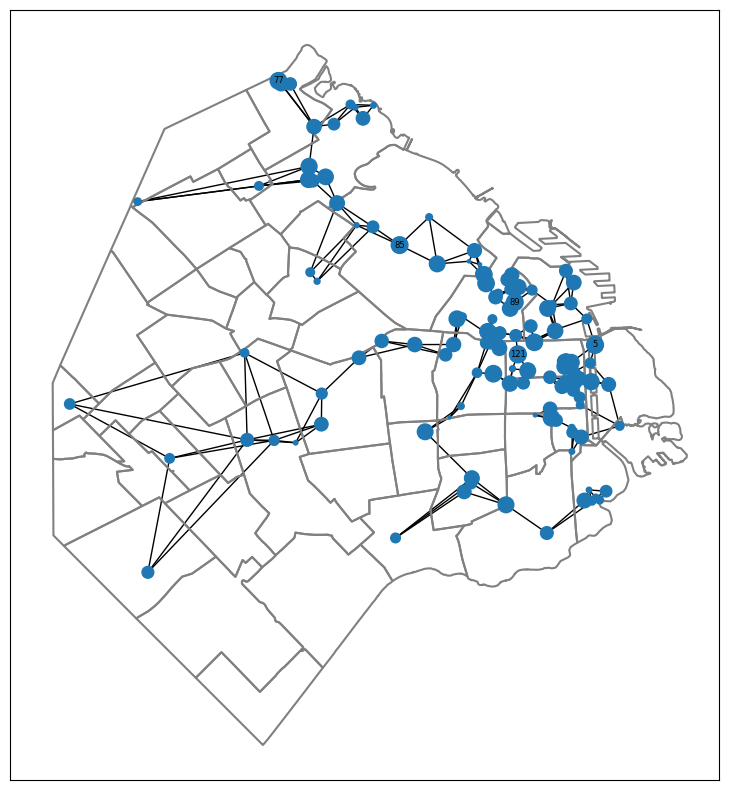

In [15]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres